В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [230]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [231]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [232]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [234]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    # hidden_layer_sizes=(100, 50,)
    def __init__(self, hidden_layer_sizes, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.hidden_layer_sizes = hidden_layer_sizes
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x):
        self.parameters = {}
        n = len(n_x)
        
        for i in range(1, len(n_x)):
            if (i == n):
                continue
            W = np.random.randn(n_x[i], n_x[i - 1]) * 0.01
            b = np.zeros((n_x[i], 1))
            self.parameters.update({f"W{i}": W, f"b{i}": b})

        W = np.random.randn(1, n_x[n-1]) * 0.01
        b = 0
        
        self.parameters.update({f"W{n}":W, f"b{n}":b})
                    
    def __forward_propagation(self, X):
        num_layers = len(self.hidden_layer_sizes)
        cache = self.parameters.copy()
        
        A = X
        for i in range(1, num_layers + 2):
            W = self.parameters[f"W{i}"]
            b = self.parameters[f"b{i}"]
            Z = np.dot(W, A) + b
            A = self.__sigmoid(Z)
            cache.update({f"Z{i}": Z})
            cache.update({f"A{i}": A})
        return A, cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        num_layers = len(self.hidden_layer_sizes)
        
        grads = {}
        
        for i in range(num_layers+1, 0, -1):
            W = cache[f"W{i}"]
            b = cache[f"b{i}"]
            Z = cache[f"Z{i}"]

            if i == num_layers + 1:
                A = cache[f"A{i}"]
                A_next = cache[f"A{i - 1}"]
                
                dZ = A - Y
                dW = 1. / m * np.dot(dZ, A_next.T)
                db = 1. / m * np.sum(dZ, axis = 1, keepdims = True)
            elif (i == 1):
                W_prev = cache[f"W{i + 1}"]
                A = cache[f"A{i}"]
                dA = np.dot(W_prev.T, dZ)

                dZ = np.multiply(dA, np.multiply(A, 1 - A))
                dW = 1. / m * np.dot(dZ, X.T)
                db = 1. / m * np.sum(dZ, axis = 1, keepdims = True)
            else:
                W_prev = cache[f"W{i + 1}"]
                A = cache[f"A{i}"]
                A_next = cache[f"A{i - 1}"]

                dA = np.dot(W_prev.T, dZ)
                dZ = np.multiply(dA, np.multiply(A, 1 - A))
                dW = 1. / m * np.dot(dZ, A_next.T)
                db = 1. / m * np.sum(dZ, axis = 1, keepdims = True)
            grads.update({f"dZ{i}":dZ, f"dW{i}":dW, f"db{i}":db})
        return grads
    
    def __update_parameters(self, grads):
        num_layers = len(self.hidden_layer_sizes)
        
        for i in range(1, num_layers + 2):
            W = self.parameters[f"W{i}"]
            b = self.parameters[f"b{i}"]
            
            dW = grads[f"dW{i}"]
            db = grads[f"db{i}"]
            
            self.parameters[f"W{i}"] = W - self.learning_rate * dW
            self.parameters[f"b{i}"] = b - self.learning_rate * db
            
    def fit(self, X_vert, Y_vert, epsilon=1e-08, print_cost = True):      
        X, Y = X_vert.T, Y_vert.T      
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)      
        costs = []       
        m = X.shape[1]
        n_x = (X.shape[0],) + self.hidden_layer_sizes   
        self.__initialize_parameters(n_x) 
        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)
            cost = self.compute_cost(A, Y)
            grads = self.__backward_propagation(X, Y, cache)
            self.__update_parameters(grads)
            costs.append(cost)
            if print_cost and i % 1000 == 0:
                print("{} iteration ==  {}".format(i, cost))
                if i > 1:
                    print(costs[-2] - costs[-1])
            if i > 1 and abs(costs[-2] - costs[-1]) < epsilon:
                print("break")
                break
                
        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
         
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        print(probs)
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)

Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [5]:
#data_columns = ["exam1", "exam2"]
#target_column = "submitted"
#df = pd.read_csv("sats.csv")
#X, Y = df[data_columns].values, df[target_column].reshape((df.shape[0], 1))
#print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [235]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


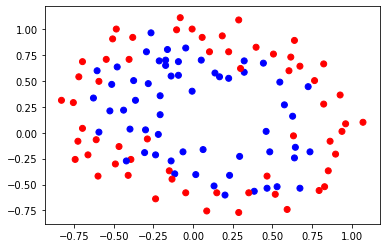

In [236]:
plot_data(X, Y)

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True)

print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(94, 2), y=(94,)
Test set: X=(24, 2), y=(24,)


0 iteration ==  0.6932435968650006
1000 iteration ==  0.692240960145259
5.700149241505414e-10
2000 iteration ==  0.6922401910847819
1.0556286955676342e-09
3000 iteration ==  0.6922385105220991
2.623916750543742e-09
4000 iteration ==  0.6922333814010186
9.437373771348234e-09
5000 iteration ==  0.6922061171061655
6.751982450925453e-08
6000 iteration ==  0.6915064431922507
3.6893806478754954e-06
7000 iteration ==  0.6758289096861799
1.087317454984138e-05
8000 iteration ==  0.6177013853697797
0.0002102307863421915
9000 iteration ==  0.456647537876295
0.00042113362988888126


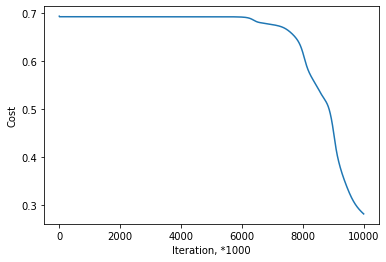

In [241]:
cls = NeuralNet((20, 10), normalize = True, learning_rate = 0.5, num_iter = 10000)
cls.fit(X_train, y_train.values.reshape((X_train.shape[0], 1)), epsilon=1e-15)

In [242]:
Y_prob = cls.predict_proba(X_test)
Y_prob

[[0.96406267 0.05711471 0.99326422 0.25014977 0.0469964  0.90739867
  0.02363304 0.12974876 0.74910737 0.11086814 0.06482029 0.15564277
  0.99435113 0.40043376 0.08286707 0.30088211 0.79190816 0.12256207
  0.12450812 0.93035409 0.87381359 0.02278813 0.97401879 0.55979891]]


array([[0.96406267, 0.03593733],
       [0.05711471, 0.94288529],
       [0.99326422, 0.00673578],
       [0.25014977, 0.74985023],
       [0.0469964 , 0.9530036 ],
       [0.90739867, 0.09260133],
       [0.02363304, 0.97636696],
       [0.12974876, 0.87025124],
       [0.74910737, 0.25089263],
       [0.11086814, 0.88913186],
       [0.06482029, 0.93517971],
       [0.15564277, 0.84435723],
       [0.99435113, 0.00564887],
       [0.40043376, 0.59956624],
       [0.08286707, 0.91713293],
       [0.30088211, 0.69911789],
       [0.79190816, 0.20809184],
       [0.12256207, 0.87743793],
       [0.12450812, 0.87549188],
       [0.93035409, 0.06964591],
       [0.87381359, 0.12618641],
       [0.02278813, 0.97721187],
       [0.97401879, 0.02598121],
       [0.55979891, 0.44020109]])

In [243]:
Y_hat = cls.predict(X_test)
Y_hat

[[0.96406267 0.05711471 0.99326422 0.25014977 0.0469964  0.90739867
  0.02363304 0.12974876 0.74910737 0.11086814 0.06482029 0.15564277
  0.99435113 0.40043376 0.08286707 0.30088211 0.79190816 0.12256207
  0.12450812 0.93035409 0.87381359 0.02278813 0.97401879 0.55979891]]


array([1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1])

In [245]:
accuracy_score(y_test, Y_hat)

0.7083333333333334

[[0.00200957 0.00204521 0.00208338 ... 0.00083882 0.00083081 0.00082317]]


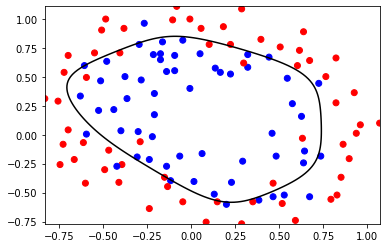

In [246]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [143]:
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 15000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')
clf.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20,), learning_rate='constant',
              learning_rate_init=0.01, max_iter=15000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

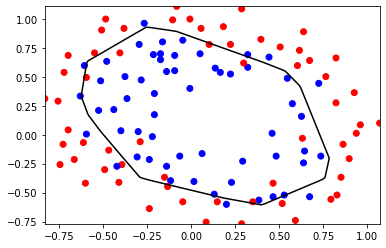

In [144]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [145]:
accuracy_score(Y, clf.predict(X))

0.8389830508474576